In [105]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sn
import matplotlib.pyplot as plt
from itertools import cycle

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

In [106]:
df_BTC = pd.read_csv('final_BTCUSDT.csv')

In [107]:
df_BTC.head()

,open_time,close_time,open,high,low,close,volume,quote_asset_volume,num_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore,open_timestamp,close_timestamp,symbol,currency
0,"12/31/2021, 23:00:00","12/31/2021, 23:59:59",46303.98,46520.13,46132.04,46216.93,985.99762,4.571976e+07,29555,484.09229,2.244919e+07,0,1640991600000,1640995199999,BTC,USDT
1,"12/31/2021, 22:00:00","12/31/2021, 22:59:59",46333.87,46569.97,46232.36,46303.99,991.85142,4.600406e+07,36280,447.96605,2.077702e+07,0,1640988000000,1640991599999,BTC,USDT
2,"12/31/2021, 21:00:00","12/31/2021, 21:59:59",45886.66,46513.67,45766.85,46333.86,1734.69585,7.997065e+07,54579,972.44065,4.482430e+07,0,1640984400000,1640987999999,BTC,USDT
3,"12/31/2021, 20:00:00","12/31/2021, 20:59:59",45728.28,46211.07,45678.00,45879.24,1831.41202,8.422142e+07,51300,997.72369,4.588270e+07,0,1640980800000,1640984399999,BTC,USDT
4,"12/31/2021, 19:00:00","12/31/2021, 19:59:59",46686.42,46688.68,45678.96,45728.28,3851.30902,1.776171e+08,87472,1691.64542,7.803749e+07,0,1640977200000,1640980799999,BTC,USDT


In [108]:
df_BTC['datetime'] = df_BTC['open_time'].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y, %H:%M:%S"))

In [109]:
df_BTC['year'] = df_BTC['datetime'].apply(lambda x: x.year)
df_BTC['month'] = df_BTC['datetime'].apply(lambda x: x.month)
df_BTC['day'] = df_BTC['datetime'].apply(lambda x: x.day)
df_BTC['hour'] = df_BTC['datetime'].apply(lambda x: x.hour)
df_BTC['day_of_week'] = df_BTC['datetime'].apply(lambda x: x.weekday())

In [116]:
df_BTC = df_BTC.groupby([df_BTC.year, df_BTC.month, df_BTC.day])['open'].min().reset_index()

In [124]:
df_BTC.head()

,year,month,day,open
0,2021,1,1,28923.63
1,2021,1,2,29197.93
2,2021,1,3,32176.45
3,2021,1,4,30270.76
4,2021,1,5,30436.26


In [125]:
df_BTC['datetime'] = pd.to_datetime(df_BTC[['year', 'month', 'day']])

In [126]:
df_BTC.head()

,year,month,day,open,datetime
0,2021,1,1,28923.63,2021-01-01
1,2021,1,2,29197.93,2021-01-02
2,2021,1,3,32176.45,2021-01-03
3,2021,1,4,30270.76,2021-01-04
4,2021,1,5,30436.26,2021-01-05


In [127]:
len(df_BTC)

887

### Viz

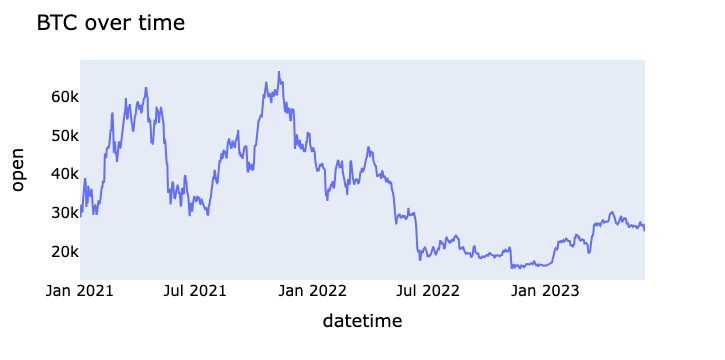

In [130]:
fig = px.line(df_BTC, x=df_BTC.datetime, y=df_BTC.open,
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='BTC over time', font_size=15, font_color='black',legend_title_text='Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

In [135]:
### We take train on data until 12am, 2023-05-29 to forecast a week afterward.

open_df = df_BTC[df_BTC.datetime > datetime.datetime(2021,6,1,0,0)][['datetime','open']]
open_df = open_df[open_df.datetime <= datetime.datetime(2023,5,30,0,0)][['datetime','open']]

# open_df = open_df.rename(columns={'datetime':'date'})

open_df.shape



(728, 2)

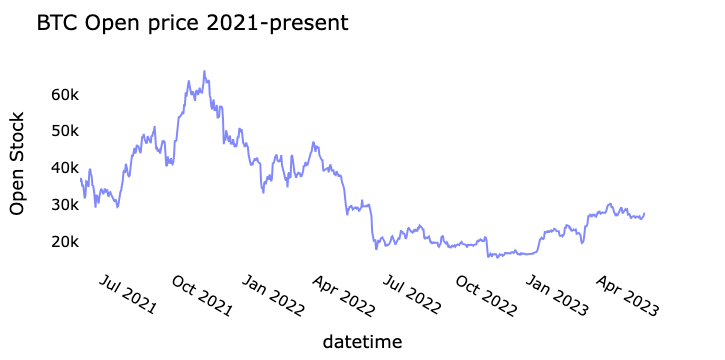

In [137]:
fig = px.line(open_df, x=open_df.datetime, y=open_df.open,labels={'date':'Date','open':'Open Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='BTC Open price 2021-present', plot_bgcolor='white', 
                  font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [140]:
from sklearn.preprocessing import MinMaxScaler

del open_df['datetime']
scaler=MinMaxScaler(feature_range=(0,1))
open_df=scaler.fit_transform(np.array(open_df).reshape(-1,1))
print(open_df.shape)

(728, 1)


In [167]:
# Train/Test Split
# Change train/test split size for testing. Default = 0.65

training_size=int(len(open_df)*0.8)
test_size=len(open_df)-training_size
train_data,test_data=open_df[0:training_size,:],open_df[training_size:len(open_df),:1]


print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (582, 1)
test_data:  (146, 1)


In [168]:

# convert an array of values into a dataset matrix

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)



In [169]:
time_step = 4

In [269]:
### Change the time_step to 12, 36, 48 etc. to see if this makes a difference
time_step = 2
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (579, 2)
y_train:  (579,)
X_test:  (143, 2)
y_test (143,)


In [270]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)



X_train:  (579, 2, 1)
X_test:  (143, 2, 1)


### LSTM

In [271]:
from tensorflow.keras.callbacks import EarlyStopping

# model=Sequential()

# model.add(LSTM(50,input_shape=(None,1),activation="relu",return_sequences=True))
# model.add(Dropout(0.1))
# model.add(LSTM(20))
# model.add(Dense(1))
# model.compile(loss="mean_squared_error",optimizer="adam")
# model.summary()

# es = EarlyStopping(patience=10, verbose=1, min_delta=0.01, monitor='loss', mode='auto', 
#                    restore_best_weights=True)


model=Sequential()

model.add(LSTM(20,input_shape=(None,1),activation="relu")) ### play around with this etc.
model.add(Dense(1))
model.compile(loss="mean_squared_error",optimizer="adam")

es = EarlyStopping(patience=20, verbose=2, min_delta=0.005, monitor='loss', mode='auto', 
                   restore_best_weights=True)

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 20)                1760      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


In [272]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=32,verbose=1,callbacks = [es])


Epoch 1/100
19/19 [==============================] - 2s 20ms/step - loss: 0.2122 - val_loss: 0.0265
Epoch 2/100
19/19 [==============================] - 0s 4ms/step - loss: 0.1678 - val_loss: 0.0146
Epoch 3/100
19/19 [==============================] - 0s 4ms/step - loss: 0.1267 - val_loss: 0.0062
Epoch 4/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0884 - val_loss: 0.0027
Epoch 5/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0549 - val_loss: 0.0058
Epoch 6/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0331 - val_loss: 0.0147
Epoch 7/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0239 - val_loss: 0.0216
Epoch 8/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0213 - val_loss: 0.0210
Epoch 9/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0186 - val_loss: 0.0162
Epoch 10/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0162 - val_loss: 0.0140
Epoch 11

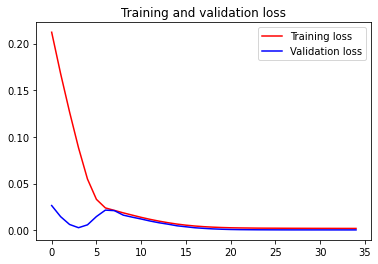

<Figure size 432x288 with 0 Axes>

In [273]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [274]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

((579, 1), (143, 1))

In [275]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 


In [276]:
import math
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))

print("-------------------------------------------------------------------------------------")

print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  3905.0777553918606
Train data MSE:  15249632.275656333
Train data MAE:  3226.940665479275
-------------------------------------------------------------------------------------
Test data RMSE:  3514.402861132312
Test data MSE:  12351027.470334979
Test data MAE:  3246.2120651223777


In [277]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9142881462954421
Test data R2 score: -0.16764626347034528


In [278]:
open_stock =  df_BTC[df_BTC.datetime > datetime.datetime(2021,6,1,0,0)][['datetime','open']]
open_stock =  open_stock[open_stock.datetime <= datetime.datetime(2023,5,30,0,0)][['datetime','open']]

Train predicted data:  (728, 1)
Test predicted data:  (728, 1)


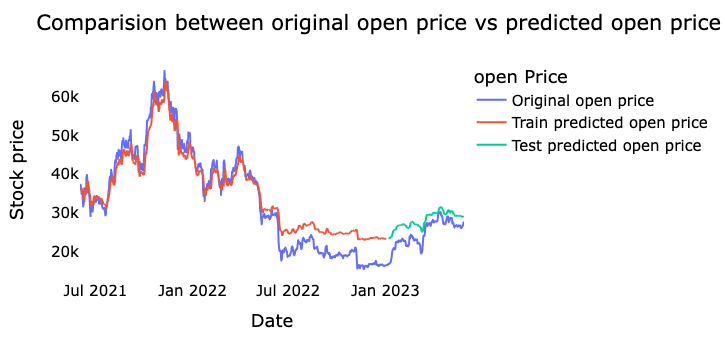

In [279]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(open_df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(open_df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(open_df)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)


names = cycle(['Original open price','Train predicted open price','Test predicted open price'])


plotdf = pd.DataFrame({'date': open_stock['datetime'],
                       'original_open': open_stock['open'],
                      'train_predicted_open': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_open': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_open'],plotdf['train_predicted_open'],
                                          plotdf['test_predicted_open']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original open price vs predicted open price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='open Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()



In [280]:

x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 60
#2 months
#7 days

while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        
           
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next 60 days: ", len(lst_output))

Output of predicted next 60 days:  60


In [281]:
# from pandas.tseries.offsets import *
# add_dates = [(open_stock['datetime'].iloc[-1] + pd.tseries.offsets.Hour(n = x)) for x in range(0,pred_hours+1)]
# future_dates = pd.DataFrame(index = add_dates[1:])
# forecast = np.array(lst_output).reshape(-1,1).tolist()

# df_predict = pd.DataFrame((scaler.inverse_transform(forecast).reshape(1,-1).tolist()[0]), index = future_dates.index, columns=['Predict open'])

# open_stock = open_stock.set_index('datetime')


# open_stock.shape, df_predict.shape

In [282]:
open_stock['datetime']

152   2021-06-02
153   2021-06-03
154   2021-06-04
155   2021-06-05
156   2021-06-06
         ...    
875   2023-05-26
876   2023-05-27
877   2023-05-28
878   2023-05-29
879   2023-05-30
Name: datetime, Length: 728, dtype: datetime64[ns]

In [283]:
from pandas.tseries.offsets import *
add_dates = [(open_stock['datetime'].iloc[-1] + datetime.timedelta(days = x)) for x in range(0,pred_days+1)]
future_dates = pd.DataFrame(index = add_dates[1:])
forecast = np.array(lst_output).reshape(-1,1).tolist()

df_predict = pd.DataFrame((scaler.inverse_transform(forecast).reshape(1,-1).tolist()[0]), index = future_dates.index, columns=['Predict open'])

open_stock = open_stock.set_index('datetime')


open_stock.shape, df_predict.shape

((728, 1), (60, 1))

In [284]:
### Check on this

In [285]:
#merging actuals + predictions
df_proj = pd.concat([open_stock,df_predict],axis=0)

df_proj.shape

(788, 2)

In [286]:
df_proj.iloc[-61]['Predict open'] = df_proj.iloc[[-61]]['open']

In [287]:
df_proj.tail(2)

,open,Predict open
2023-07-28,NaN,34982.022499
2023-07-29,NaN,34982.037660


In [288]:
# df_proj.iloc[-169]['Predict open'] = df_proj.iloc[[-169]]['open']

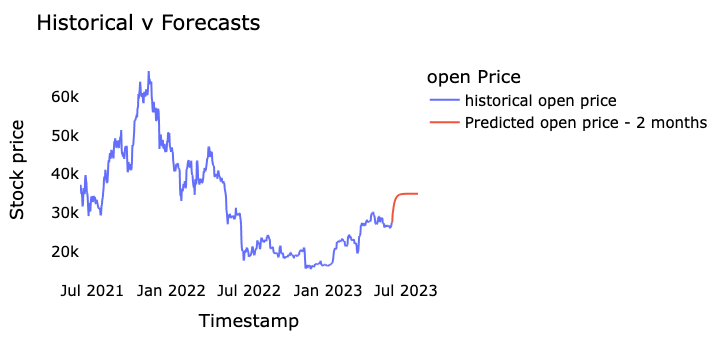

In [289]:
names = cycle(['historical open price','Predicted open price - 2 months'])

fig = px.line(df_proj,x=df_proj.index, y=[df_proj['open'],df_proj['Predict open']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Historical v Forecasts',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='open Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()


In [290]:
open_stock_full = df_BTC[df_BTC.datetime > datetime.datetime(2021,6,1,0,0)][['datetime','open']]
open_stock_full = open_stock_full[open_stock_full.datetime <= datetime.datetime(2023,7,29,0,0)]
open_stock_full.shape

(735, 2)

In [291]:
# names = cycle(['historical open price','Predicted open price - 7 days/168 hours'])

# fig = px.line(df_proj,x=df_proj.index, y=[open_stock_full['open'],df_proj['Predict open']],
#               labels={'value': 'Stock price','index': 'Timestamp'})
# fig.update_layout(title_text='BTC Historical v Forecasts',
#                   plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='open Price')

# fig.for_each_trace(lambda t:  t.update(name = next(names)))

# fig.update_xaxes(showgrid=False)
# fig.update_yaxes(showgrid=False)
# fig.show()



In [292]:
### TODO do above for after the 29th etc.

In [293]:
df_proj_rest = df_proj.reset_index()[df_proj.reset_index()['index'] > datetime.datetime(2023,5,20,0)]

In [294]:
# names = cycle(['historical open price','Predicted open price - 7 days/168 hour'])

# fig = px.line(df_proj,x=df_proj_rest.index, y=[open_stock_full[open_stock_full.datetime > datetime.datetime(2023,5,20,0)]['open'],df_proj_rest['Predict open']],
#               labels={'value': 'Stock price','index': 'Timestamp'})
# fig.update_layout(title_text='BTC Historical v Forecasts (Recent)',
#                   plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='open Price')

# fig.for_each_trace(lambda t:  t.update(name = next(names)))

# fig.update_xaxes(showgrid=False)
# fig.update_yaxes(showgrid=False)